In [1]:
from hamamatsu.dcamapi_helpers import *
import cv2

iDevice = 0  # Define the index of the device
exposure_time_id=0x001F0110

def dcamtest_show_framedata(data, windowtitle, iShown):
    """
    Show numpy buffer as an image

    Arg1:   NumPy array
    Arg2:   Window name
    Arg3:   Last window status.
        0   open as a new window
        <0  already closed
        >0  already openend
    """
    if iShown > 0 and cv2.getWindowProperty(windowtitle, 0) < 0:
        return -1  # Window has been closed.
    if iShown < 0:
        return -1  # Window is already closed.

    if data.dtype == np.uint16:
        imax = np.amax(data)
        if imax > 0:
            imul = int(65535 / imax)
            # print('Multiple %s' % imul)
            data = data * imul

        cv2.imshow(windowtitle, data)
        return 1
    else:
        print('-NG: dcamtest_show_image(data) only support Numpy.uint16 data')
        return -1


if Dcamapi.init() is True:  # initialize Dcamapi, return True if succeeded.
    print('dcamapi initialized')
    dcam = Dcam(iDevice)  # define the instance of the device
    print('created camera instance')
    if dcam.dev_open() is True:  # open the device, return True if succeeded.
        dcam.prop_setgetvalue(exposure_time_id, 1)
        if dcam.buf_alloc(1) is True:  # allocate buffer for the device.
            ###############################################################

            # dcamtest_thread_live(dcam)  # live acquisition
            if dcam.cap_start() is True:  # capturing start
                timeout_milisec = 1000  # define a time out value in ms.
                iWindowStatus = 0  # ??
                imind=0
                while iWindowStatus >= 0:
                    if dcam.wait_capevent_frameready(timeout_milisec) is True:  # ??
                        data = dcam.buf_getlastframedata()  # read out the last frame
                        print('image'+str(imind))
                        imind+=1
                        iWindowStatus = dcamtest_show_framedata(data, 'test', iWindowStatus)
                    else:
                        dcamerr = dcam.lasterr()
                        if dcamerr.is_timeout():
                            print('===: timeout')
                        else:
                            print('-NG: Dcam.wait_event() fails with error {}'.format(dcamerr))
                            break

                    key = cv2.waitKey(1)
                    if key == ord('q') or key == ord('Q'):  # if 'q' was pressed with the live window, close it
                        break

                dcam.cap_stop()

            ###############################################################

            dcam.buf_release()  # release the buffer
        dcam.dev_close()
Dcamapi.uninit()


dcamapi initialized
created camera instance
===: timeout
image0
image1
image2
image3
image4
image5
image6
image7


True

In [2]:
from hamamatsu.dcamapi_helpers import *
import cv2

In [3]:
Dcamapi.init()

True

In [4]:
dcam = Dcam(iDevice=0)

In [5]:
dcam.dev_open()

True

In [6]:
propid=0x001F0110 # this is the proper ID for exposure time

In [7]:
dcam.prop_getvalue(propid)

0.009997714285714285

In [8]:
dcam.prop_setgetvalue(propid, 0.1)

0.10000637593984962

In [20]:
dcam.dev_close()

True

In [2]:
2**3

8

In [89]:
# try to write a soft retraction function with flat top and bottom
# [current] - 2:13 pm.
import numpy as np
from matplotlib import pyplot as plt
v1 = 0
v2 = 5
N = 10 # half sample number
a = (v2-v1)/N**2
b = v1
xs = np.arange(N)
ys = a*xs**2+b
# the goal is to ramp from v1 to v2 within N data points, with minimum acceleration.

def soft_retraction(v0, v1, Ntotal, generate_plot=True):
    N=np.floor(Ntotal/2) # leave enough redundancy on both ends.
    xs=np.arange(int(N*2+1))+1
    ys=np.ones(int(N*2+1))*v1
    a=(v1-v0)/2/(N)**2 # acceleration
    b=v0 # offset
    x=np.arange(N)+1 # prepare a half curve indexes.
    y=a*x**2 + b # calcualte half of the acceleration curve
    y2=list(y[:-1]) + list(np.flip(-y+2*(y[-1]))) # flip it up
    print(len(y2))
    print(len(ys))
    print(ys)
    
    ys[:len(y2)]=y2 # copy over the datapoints
    if generate_plot:
        plt.plot(xs, ys)
        plt.plot(x,y,'r')
    return xs, ys
    
    

In [ ]:
def soft_retraction_withramp(vramp, v0, v1, Ntotal, generate_plot=True):
    N=np.floor(Ntotal/2) # leave enough redundancy on both ends.
    xs=np.arange(int(N*2+1))+1
    ys=np.ones(int(N*2+1))*v1
    """
    y(x)=a*(x-c)**2 + b
    y(0) = v0 = ac**2 + b
    y[n] = v1 = a(n-c)**2 + b =an**2 +ac**2 -2anc + b
    dydx=2*a*(0-c)+b=vramp = -2ac+b
    
    b=v0-ac^2
    v1 = an^2 +v0 - 2anc
    v1 - v0 = an^2 - 2anc
    a = (v1-10)/(n^2-2nc)
    vramp = -2ac + v0-ac^2 = v0-a(2c+c^2) = v0-(v1-v0)/(n^2 - 2nc) * (2c+c^2)
    
    solve this equation - leave for future.
    
    """
    a=(v1-v0)/2/(N)**2 # acceleration
    b=v0 # offset
    x=np.arange(N)+1 # prepare a half curve indexes.
    y=a*x**2 + b # calcualte half of the acceleration curve
    y2=list(y[:-1]) + list(np.flip(-y+2*(y[-1]))) # flip it up
    print(len(y2))
    print(len(ys))
    print(ys)
    
    ys[:len(y2)]=y2 # copy over the datapoints
    if generate_plot:
        plt.plot(xs, ys)
        plt.plot(x,y,'r')
    return xs, ys

19
21
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100.]


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21]),
 array([ 80.1,  80.4,  80.9,  81.6,  82.5,  83.6,  84.9,  86.4,  88.1,
         90. ,  91.9,  93.6,  95.1,  96.4,  97.5,  98.4,  99.1,  99.6,
         99.9, 100. , 100. ]))

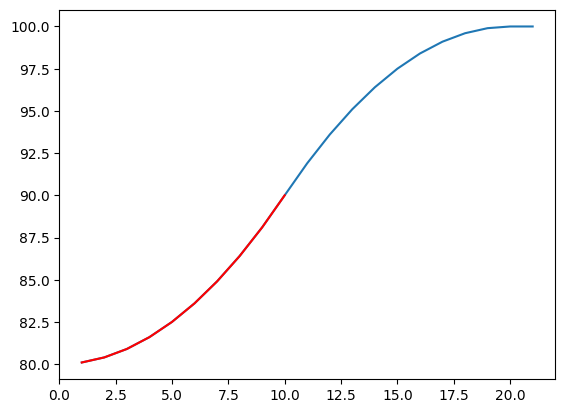

In [90]:
soft_retraction(v0=80, v1=100, Ntotal=20, generate_plot=True)

19
10


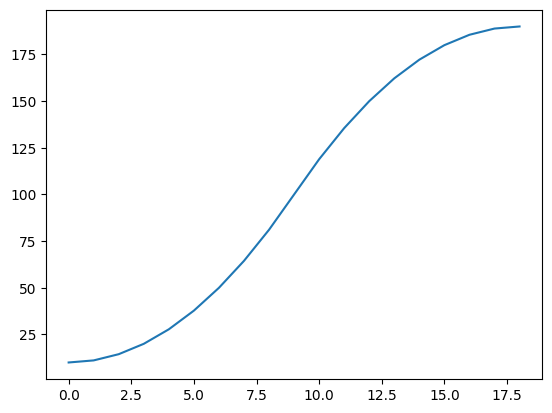

In [98]:
# y = ax**2 + b
# when x==0, y=b=v0, when x==N-1, y=v1=a*(N-1)**2+v0; so a = (v1-v0)/(N-1)**2

v0=10
v1=100
N=10
# so

a = (v1-v0)/(N-1)**2
b = v0

x=np.arange(N)
y = a*x**2 + b

# 2 segment would be:
ys = list(y[:-1]) + list(-np.flip(y) + 2*y[-1])
plt.plot(ys)
print(len(ys))
print(N)

In [116]:
def soft_retraction(v0, v1, n_total, plot_option=False):
    """
    this function generate a soft retraction curve that rampls from v0 to v1 over n_total data points.
    the retraction would keep a constant amplitude of acceleration throughout the curve, with inverse signs
    for each half of the curve.
    """
    N = np.floor(n_total/2)-1 # calculate the half-curve data points, with 1 extra data point of buffer.
    
    a = (v1-v0)/2/(N-1)**2 # calculate the acceleration a in equation y(x) = a*x**2 + b
    b = v0 # calculate the offset b in equation y(x) = a*x**2 + b

    x=np.arange(N) # prepare location coordiantes
    y = a*x**2 + b # calculate position sequences.

    # patch two segments of the positions to create two segments with flipped acceleration sign.
    ys_mid = list(y[:-1]) + list(-np.flip(y) + 2*y[-1])
    # prepare an empty vecgor for the final position sequence, and it should end at v1.
    ys=np.ones(n_total)*v1
    
    # position should starts at v0
    ys[0]=v0
    
    # in the middle we copy over the calculated soft retraction curve
    ys[1:len(ys_mid)+1]=ys_mid
    
    # inspection
    if plot_option:
        plt.plot(ys,'.-')
        plt.plot(len(ys)-1, v1,'ro')
        plt.plot(0, v0,'ro')
        
    return(ys)

array([ 10.      ,  10.      ,  10.703125,  12.8125  ,  16.328125,
        21.25    ,  27.578125,  35.3125  ,  44.453125,  55.      ,
        65.546875,  74.6875  ,  82.421875,  88.75    ,  93.671875,
        97.1875  ,  99.296875, 100.      , 100.      , 100.      ])

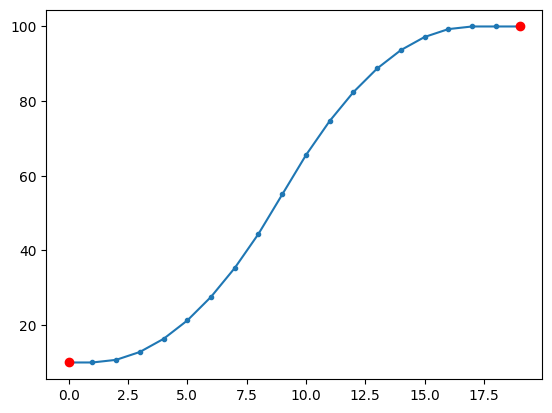

In [117]:
soft_retraction(v0=10, v1=100, n_total=20, plot_option=True)

In [1]:
from daxi.ctr_devicesfacilitator.nidaq.devicetools.generate_functions import DAQDataGenerator

In [2]:
m=DAQDataGenerator()

In [7]:
y=m.getfcn_linear_ramp_soft_retraction(v0=0, v1=0.5, n_sample_ramp=1000, n_sample_retraction=100)

In [8]:
from matplotlib import pyplot as plt

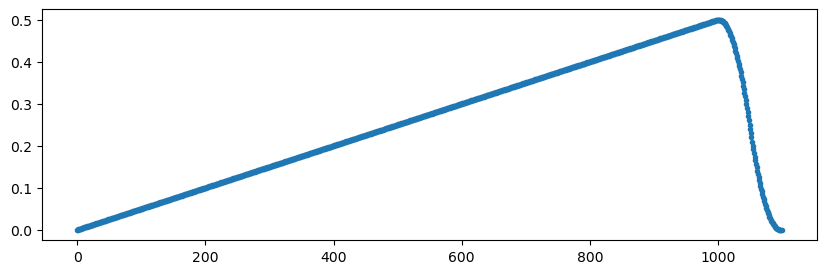

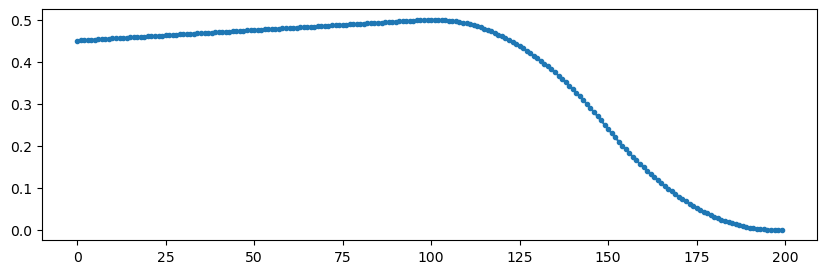

In [13]:
plt.figure(figsize=(10,3))
plt.plot(y,'.-')
plt.figure(figsize=(10,3))
plt.plot(y[900:1100],'.-')
